In [ ]:
!pip install opencv-python
!pip install tensorflow
!pip install image-similarity-measures
!pip install gdown

In [1]:
import sys
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.utils as image
import image_similarity_measures
from image_similarity_measures.quality_metrics import rmse, ssim, sre
from collections import Counter
import time
from datetime import datetime
import pandas as pd
import gdown

In [2]:
file_path = "file.zip"
#download the test set
if not os.path.exists("Test Set/"):
    gdown.download("https://drive.google.com/uc?id=1W94tVozlrHMY_SWE-45TvWT5PqQjElxc&confirm=t", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

#download the face weights
if not os.path.exists("Face Weights/"):
    gdown.download("https://drive.google.com/uc?id=1xxv9arylSUjjDoe8E5wwwLoMUQLl1bxT&confirm=t", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

#Load the Gender Model
if not os.path.exists("Gender Model/"):
    gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc&confirm=t", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
gender_model = keras.models.load_model('Gender Model/')

#Load the Emotion Model
if not os.path.exists("Emotions Model/"):
    gdown.download("https://drive.google.com/uc?id=1zwwyyd0CZZBDOYt6vSliejyq7NrGbRsT&confirm=t", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
emotions_model = keras.models.load_model('Emotions Model/')

#Download the videos to test
if not os.path.exists("children.mp4") or not os.path.exists("people.mp4"):
    gdown.download("https://drive.google.com/uc?id=1IN-fUHgI3hG0wslmZPkfVS8ZJNGdtvF1&confirm=t", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [3]:
gender_img_height = 378
gender_img_width = 378
emotions_img_height = 224
emotions_img_width = 224
gender_class_names = ["Man", "Woman"]
emotions_class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [11]:
import warnings
warnings.filterwarnings("ignore")

#take an image and return the image ready to be used as input for the net
def prepare_img(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images

#only for live analysis, write over the face detection the most two probable emotions
def write_on_box(frame, gender, x, y, h, emotions):
    c = 10
    cv2.putText(frame, gender, (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    for key, value in emotions.items():
        if c < 70:
            cv2.putText(
                frame, 
                str(key) + " " + str(value)[:4], 
                (x, y-c), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.9, 
                (36,255,12), 
                2
            )
            c += 30

#draw a polar char where a point show the emotion, works with multiple person
def emotions_chart(emotions, gender, emotions_classes, live, history_dict):
    tmp_emotions_class_names = np.insert(emotions_class_names, 6, "")
    tmp_emotions_classes = np.insert(emotions_classes.flatten(), 6, 0)
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(111, projection='polar')
    ax.set_xticklabels(tmp_emotions_class_names)
    theta = np.arange( 0, 2*np.pi, 2*np.pi/8)
    #if the method is called live
    if bool(history_dict):
        for label in history_dict.keys():
            tmp = history_dict[label][-1]
            iterator = iter(tmp)
            next(iterator)
            key = next(iterator)
            i = np.where(tmp_emotions_class_names == key)[0][0]
            ax.scatter(theta[i], tmp[key], 100, label=label)
            ax.legend()
    #if the method is called for an image
    else:
        key = next(iter(emotions))
        i = np.where(tmp_emotions_class_names == key)[0][0]
        ax.scatter(theta[i], tmp_emotions_classes[i], 100)

    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img  = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
    if live:
        cv2.imshow("chart", img)
        ax.set_visible(False)
        save_history(gender, emotions)

def save_history(gender, emotions):
    global history
    history = np.append(history, {"Gender": gender, **emotions})

#return the best score fo the similarities
def calc_closest_val(similarity, checkMax):
    result = {}

    if (checkMax):
        closest = max(similarity.values())
    else:
        closest = min(similarity.values())
    
    for key, value in similarity.items():
        if (value == closest):
            result[key] = closest
            
    return result

#return the predict gender
def find_gender(img):
    gender_classes = gender_classes_func(img)
    return gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]]

#return the predict emotions
def find_emotions(img):
    tmp_dictionary = dict()
    emotions = dict()
    emotions_classes = emotions_classes_func(img)
    index = list(np.where(np.where(emotions_classes > 0, 1, 0)[0] == 1)[0])
    for i in index:
        tmp_dictionary[emotions_class_names[i]] = emotions_classes[0][i]
    sorted_keys = sorted(tmp_dictionary, key=tmp_dictionary.get, reverse=True)
    for k in sorted_keys:
        emotions[k] = tmp_dictionary[k]*100
    return emotions

#return all the emotions classes and scores
def emotions_classes_func(img):
    emotions_img = cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width))
    return emotions_model.predict(prepare_img(emotions_img))

#return all the gender classes and scores
def gender_classes_func(img):
    gender_img = cv2.resize(np.float32(img), (gender_img_height, gender_img_width))
    return gender_model.predict(prepare_img(gender_img))

#check if the face has already been seen on camera and return a score of similarity
def calc_similarity(template_faces, face, dim, thr_ssim, thr_sre):
    ssim_measures = dict()
    rmse_measures = dict()
    sre_measures = dict()
    for key in template_faces.keys():
        resized_img = cv2.resize(template_faces[key], dim, interpolation = cv2.INTER_AREA)
        ssim_measures[key]= ssim(face, resized_img)
        rmse_measures[key]= rmse(face, resized_img)
        sre_measures[key]= sre(face, resized_img)
    ssim_dict = calc_closest_val(ssim_measures, True)
    rmse_dict = calc_closest_val(rmse_measures, False)
    sre_dict = calc_closest_val(sre_measures, True)
    key1 = next(iter(ssim_dict))
    key2 = next(iter(rmse_dict))
    key3 = next(iter(sre_dict))
    if ssim_dict[key1] > np.mean(thr_ssim) or sre_dict[key3] > np.mean(thr_sre):
        return (Counter([key1,key2,key3]).most_common(1)[0][0], ssim_dict[key1], sre_dict[key3])
    else:
        return ("", ssim_dict[key1], sre_dict[key3])

#add a new face to the temporary set
def new_person(template_faces, history_dict, faces_index, face, history):
    template_faces[f"Person{faces_index}"] = face
    history_dict[f"Person{faces_index}"] = history
    faces_index += 1
    return (template_faces, history_dict, faces_index)

#create a line chart related to the time passed and the emotions
def final_chart(history_dict):
    for person in history_dict.keys():
        single_list = history_dict[person].tolist()
        if len(single_list) > 1:
            df = pd.DataFrame(single_list)
            df = df.drop(columns="Gender")

            df.plot(kind='line', stacked=False, figsize = (7,4))
            plt.legend(loc="center left", bbox_to_anchor=(1.0,0.5))
            plt.xticks(np.arange(len(df)), np.arange(1, len(df)+1), rotation=0)
            plt.xlabel("Time (s)")
            plt.ylabel("Emotions Prediction")
            plt.savefig(f'chart of {person}.png', bbox_inches="tight")
        
def write_on_text(history_dict):
    t = ""
    for person, emotions in history_dict.items():
        if len(emotions) > 1:
            t = t + person + "\n"
            for emotion in emotions:
                for name, prediction in emotion.items():
                    t = t + ("{} ({})".format(name, prediction)) + "\n"
                t = t + "\n"
            t = t + "\n"
    with open(f'Analysis {datetime.now().strftime("%H_%M_%S %d_%m_%Y")}.txt', 'w') as f:
        f.write(t)
    

In [ ]:
#Load and Predict an image
img = image.load_img("Test Set/Gender/woman/100.png", color_mode = "grayscale")
face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')
faces = face_cascade.detectMultiScale(np.array(img))
for (x, y, w, h) in faces:
    gender = find_gender(np.array(img)[y:y+h, x:x+w])
    emotions = find_emotions(np.array(img)[y:y+h, x:x+w])

print(gender + " " + str(emotions)[1:-1])

plt.imshow(cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width)), cmap="gray")

emotions_chart(emotions, gender, emotions_classes_func(img), False, {})

1/1 [==============================] - 0s 21ms/step


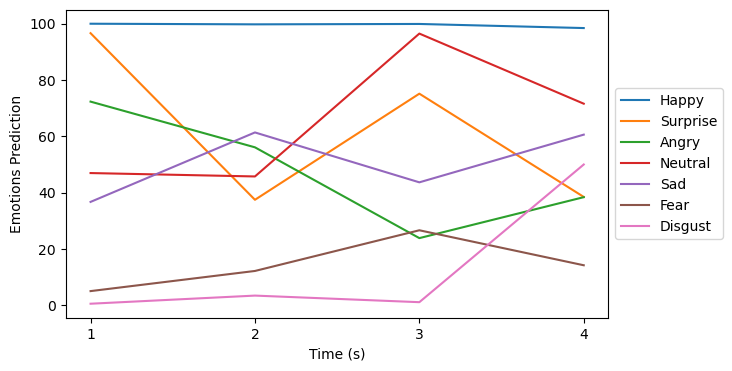

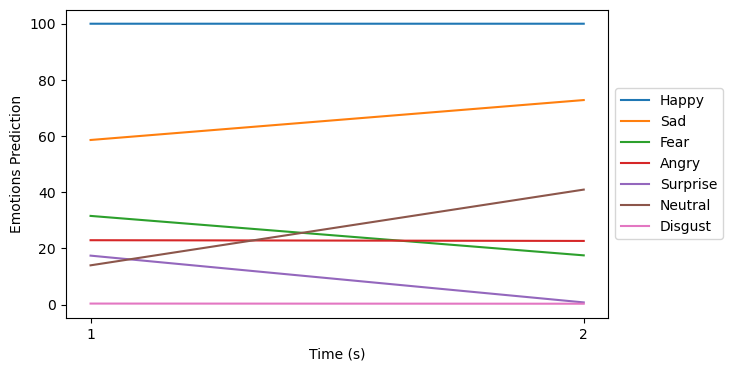

In [13]:
#Video Analyzer
videos = ["children.mp4", "people.mp4"]
cap = cv2.VideoCapture(videos[0])

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
skip = 0
size = (frame_width,frame_height)
if skip == 0:
    fps_out = fps
else:
    fps_out = fps/skip

out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'MP4V'), fps_out, size)
face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')

skip_frames = int(fps_out)
cur_frames = 0

template_faces = dict()
faces_index = 1
history_dict = dict()

emotions_tmp = {}
gender_tmp = {}

ssim_dynamic_similarity = [0.85]
sre_dynamic_similarity = [50]

while True:
    for i in range(skip-1):
        cap.read()
    ret, frame = cap.read()
    if ret:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            if w > 150 and h > 150:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (36,255,12), 2)
                face = frame[y:y+h, x:x+w]
                dim = (int(face.shape[1]),int(face.shape[0]))
                if process_frame:
                    history = np.array([])
                    face_gray = gray[y:y+h, x:x+w]
                    
                    gender = find_gender(face_gray)
                    emotions = find_emotions(face_gray)
                    
                    write_on_box(frame, gender, x, y, h, emotions)
                    save_history(gender, emotions)
                    if len(template_faces) > 0:
                        key, ssim_val, sre_val = calc_similarity(template_faces, face, dim, ssim_dynamic_similarity, sre_dynamic_similarity)
                        ssim_dynamic_similarity.append(ssim_val)
                        sre_dynamic_similarity.append(sre_val)
                        if key in history_dict:
                            history_dict[key] = np.append(history_dict[key], history)
                            gender_tmp[key] = gender
                            emotions_tmp[key] = emotions
                        else:
                            template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                            gender_tmp[f"Person{faces_index-1}"] = gender
                            emotions_tmp[f"Person{faces_index-1}"] = emotions
                    else:
                        template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                        gender_tmp["Person1"] = gender
                        emotions_tmp["Person1"] = emotions
                else:
                    if len(template_faces) > 0:
                        key, _, _ = calc_similarity(template_faces, face, dim, ssim_dynamic_similarity, sre_dynamic_similarity)
                        if key in gender_tmp:
                            write_on_box(frame, gender_tmp[key], x, y, h, emotions_tmp[key])
        out.write(frame)
        cur_frames += 1
    else:
        break
cap.release()
out.release()
cv2.destroyAllWindows()
write_on_text(history_dict)
final_chart(history_dict)

In [ ]:
#Live Analyzer
cap = cv2.VideoCapture(0)
if not cap.isOpened(): 
    print("Unable to read camera feed")

fps = cap.get(cv2.CAP_PROP_FPS)
face_cascade = cv2.CascadeClassifier('Face Weights/haarcascade_frontalface_alt.xml')

skip_frames = int(fps)/2
cur_frames = 0

template_faces = dict()
faces_index = 1
history_dict = dict()

emotions_tmp = {}
gender_tmp = {}

ssim_dynamic_similarity = [0.75]
sre_dynamic_similarity = [50]

while True:
    for i in range(1):
        cap.read()
    ret, frame = cap.read()
    if ret:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            if w > 100 and h > 100:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (36,255,12), 2)
                face = frame[y:y+h, x:x+w]
                dim = (int(face.shape[1]),int(face.shape[0]))
                if process_frame:
                    history = np.array([])
                    face_gray = gray[y:y+h, x:x+w]

                    gender = find_gender(face_gray)
                    emotions = find_emotions(face_gray)
                    
                    write_on_box(frame, gender, x, y, h, emotions)
                    emotions_chart(emotions, gender, emotions_classes_func(face_gray), True, history_dict)

                    if len(template_faces) > 0:
                        key, ssim_val, sre_val = calc_similarity(template_faces, face, dim, ssim_dynamic_similarity, sre_dynamic_similarity)
                        ssim_dynamic_similarity.append(ssim_val)
                        sre_dynamic_similarity.append(sre_val)
                        if key in history_dict:
                            history_dict[key] = np.append(history_dict[key], history)
                            gender_tmp[key] = gender
                            emotions_tmp[key] = emotions
                        else:
                            template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                            gender_tmp[f"Person{faces_index-1}"] = gender
                            emotions_tmp[f"Person{faces_index-1}"] = emotions
                    else:
                        template_faces, history_dict, faces_index = new_person(template_faces, history_dict, faces_index, face, history)
                        gender_tmp["Person1"] = gender
                        emotions_tmp["Person1"] = emotions
                else:
                    if len(template_faces) > 0:
                        key, _, _ = calc_similarity(template_faces, face, dim, ssim_dynamic_similarity, sre_dynamic_similarity)
                        if key in gender_tmp:
                            write_on_box(frame, gender_tmp[key], x, y, h, emotions_tmp[key])
        cv2.imshow('frame', frame)
        cur_frames += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            break
    else:
        break

cap.release()
cv2.destroyAllWindows()
write_on_text(history_dict)
final_chart(history_dict)